In [2]:
import numpy as np
import xarray as xr
import os
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warnings.filterwarnings('ignore')

### some functions

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import eofs.xarray as xe
from sklearn.cluster import KMeans, DBSCAN
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from sklearn.preprocessing import StandardScaler

def plot_swc_mean(ds_era5, ds_planet, inames_files, swc_min_era5=0.1, swc_max_era5=0.45, save_path='./figs/'):
    """
    Plots and saves mean soil water content (SWC) from ERA5 and Planet datasets.

    Parameters:
    - ds_era5: xarray Dataset containing ERA5 data with 'swvl1' variable.
    - ds_planet: xarray Dataset containing Planet data with 'swc' variable.
    - inames_files: str, identifier for filenames and titles.
    - swc_min_era5: float, minimum SWC value for ERA5 colormap.
    - swc_max_era5: float, maximum SWC value for ERA5 colormap.
    - save_path: str, directory to save the generated figure.
    """
    # Extract variables
    var_era5 = ds_era5['swvl1']
    var_planet = ds_planet['swc']
    
    # Get spatial bounds from Planet data
    lon_min, lon_max = ds_planet.lon.min().item(), ds_planet.lon.max().item()
    lat_min, lat_max = ds_planet.lat.min().item(), ds_planet.lat.max().item()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Plot mean SWC from ERA5
    var_era5.mean(dim='time').plot(ax=axes[0, 0], cmap='viridis', vmin=swc_min_era5, vmax=swc_max_era5)
    axes[0, 0].set_title("ERA5 aoi 1990-2024")
    
    # Add red rectangle to show AOI
    #rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=2, edgecolor='red', facecolor='none')
    #axes[0, 0].add_patch(rect)
            
    # Compute the mean along the time dimension
    swc_mean = var_planet.mean(dim='time')
    
    # Find the coordinates of non-NaN values
    non_nan_mask = ~np.isnan(swc_mean.values)
    lon_coords, lat_coords = np.meshgrid(swc_mean.lon.values, swc_mean.lat.values)
    non_nan_coords = np.column_stack([lon_coords[non_nan_mask], lat_coords[non_nan_mask]])
    
    # Compute the convex hull around the non-NaN points
    if non_nan_coords.size > 0:
        hull = ConvexHull(non_nan_coords)
        polygon_coords = non_nan_coords[hull.vertices]
    else:
        polygon_coords = []

    # Add the polygon if it exists
    if polygon_coords.size > 0:
        poly_patch = Polygon(polygon_coords, closed=True, edgecolor='red', facecolor='none', linewidth=2)
        axes[0, 1].add_patch(poly_patch)

    # plot mean SWC from Planet
    var_planet.mean(dim='time').plot(ax=axes[0, 1], cmap='plasma')
    axes[0, 1].set_title(f"Planet {inames_files}")
    
    # crop ERA5 to AOI and plot
    var_era5_cropped = var_era5.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
    var_era5_cropped.mean(dim='time').plot(ax=axes[1, 0], cmap='viridis', vmin=swc_min_era5, vmax=swc_max_era5)
    axes[1, 0].set_title("ERA5 AOI 1990-2024 (Cropped)")
    axes[1, 0].set_xlim(lon_min, lon_max)
    axes[1, 0].set_ylim(lat_min, lat_max)
    
    var_planet.mean(dim='time').plot(ax=axes[1, 1], cmap='plasma')
    axes[1, 1].set_title(f"Planet {inames_files}")
    
    fig.savefig(f"{save_path}location_{inames_files}_with_ERA5.png", dpi=400)
    plt.close(fig)

# compute descriptive statistics for SWC
def descriptive_statistics(data):
    swc_values = data['swc'].values.flatten()
    swc_values = swc_values[~np.isnan(swc_values)]  # remove NaN values
    stats = {
        'Mean': np.mean(swc_values),
        'Median': np.median(swc_values),
        'Standard Deviation': np.std(swc_values),
        'Minimum': np.min(swc_values),
        'Maximum': np.max(swc_values),
    }
    return pd.DataFrame(stats, index=["SWC"]).T

# Define functions for the requested visualizations and computations

def plot_histogram(data):
    """
    Plots a histogram of the SWC values.
    """
    percentiles=[10, 25, 50, 75, 90]
    
    # Flatten the data and remove NaNs
    swc_values = data['swc'].values.flatten()
    swc_values = swc_values[~np.isnan(swc_values)]
    
    # percentiles
    percentile_values = np.percentile(swc_values, percentiles)
        
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])
    ax.hist(swc_values, bins=50, color='limegreen', alpha=0.7)
    ax.set_title("Distribution of SWC")
    ax.set_xlabel("SWC Value")
    ax.set_ylabel("Frequency")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # percentile markers
    for p, val in zip(percentiles, percentile_values):
        ax.axvline(val, color='grey', linestyle='-', linewidth=0.5)
        ax.text(val, ax.get_ylim()[1] * 0.9, f'{p}%', color='grey', rotation=90, ha='center', va='center')
    
    
    plt.show()

def plot_histogram_by_season(data, percentiles=[10, 25, 50, 75, 90]):
    """
    Plots histograms of SWC values for each season in the same plot with different shades and includes percentiles.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - percentiles: List of percentiles to calculate and show on the overall distribution.
    """
    # Define seasons and their respective months
    seasons = {
        'DJF': [12, 1, 2],
        'MAM': [3, 4, 5],
        'JJA': [6, 7, 8],
        'SON': [9, 10, 11]
    }
    
    # Colors for each season
    colors = {'DJF': 'blue', 'MAM': 'green', 'JJA': 'orange', 'SON': 'purple'}
    
    # Overall SWC values
    swc_values = data['swc'].values.flatten()
    swc_values = swc_values[~np.isnan(swc_values)]
    
    # Calculate percentiles for overall distribution
    overall_percentiles = np.percentile(swc_values, percentiles)
    
    # Create the plot
    fig = plt.figure(figsize=(8, 4))
    ax = plt.gca()
    
    # Plot histograms for each season
    for season, months in seasons.items():
        # Filter data for the season
        season_data = data.sel(time=data['time.month'].isin(months))
        season_values = season_data['swc'].values.flatten()
        season_values = season_values[~np.isnan(season_values)]
        
        # Plot the histogram
        ax.hist(season_values, bins=50, color=colors[season], alpha=0.4, label=f'{season}')
    
    # Plot overall percentiles
    for p, val in zip(percentiles, overall_percentiles):
        ax.axvline(val, color='red', linestyle='--', linewidth=1)
        ax.text(val, ax.get_ylim()[1] * 0.8, f'{p}%', color='grey', rotation=90, ha='center', va='center')
    
    # Customize the plot
    ax.set_title("Distribution of SWC by Season with Percentiles")
    ax.set_xlabel("SWC Value")
    ax.set_ylabel("Frequency")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(title="Seasons")
    plt.tight_layout()
    plt.show()


def plot_time_series(data):
    """
    Plots a time series of the average SWC over the region for each time point.
    """
    avg_swc_time = data['swc'].mean(dim=['lat', 'lon']).values
    fig = plt.figure(figsize=(10, 4))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])
    ax.plot(data['time'].values, avg_swc_time, lw=0.5, label='Average SWC', color='seagreen')
    ax.set_title("Time series of averaged SWC")
    ax.set_xlabel("Time")
    ax.set_ylabel("SWC [fraction]")
    #ax.legend()
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()


def plot_time_series_two(data1, data2):
    """
    Plots a time series of the average SWC over the region for each time point.
    """
    avg_swc_time1 = data1['swc'].mean(dim=['lat', 'lon']).values
    avg_swc_time2 = data2['swc'].mean(dim=['lat', 'lon']).values

    fig = plt.figure(figsize=(10, 4))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])
    ax.plot(data1['time'].values, avg_swc_time1, lw=0.5, label='Average SWC data 1', color='blue')
    ax.plot(data2['time'].values, avg_swc_time2, lw=0.5, label='Average SWC data 2', color='salmon')
    ax.set_title("Time series of averaged SWC")
    ax.set_xlabel("Time")
    ax.set_ylabel("SWC [fraction]")
    #ax.legend()
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

def plot_spatial_mean(data):
    """
    Plots a heatmap of the average SWC across time for spatial distribution.
    """
    avg_swc_space = data['swc'].mean(dim='time')
    levels = np.linspace(0.19, 0.26, 21)

    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes([0.05, 0.05, 0.85, 0.85])    
    contour = ax.contourf(data['lon'], data['lat'], avg_swc_space, cmap='BrBG', levels=levels, extend='both')
    ax.set_title("Time mean SWC")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(contour, label="SWC")
    plt.grid(True)
    plt.show()
    
def plot_seasonal_spatial_means(data):
    """
    Computes and plots the spatial mean of SWC for all seasons (DJF, MAM, JJA, SON) in a single figure with 4 panels.
    """
    # Define seasons and their respective months
    seasons = {
        'DJF': [12, 1, 2],
        'MAM': [3, 4, 5],
        'JJA': [6, 7, 8],
        'SON': [9, 10, 11]
    }
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, (season, months) in enumerate(seasons.items()):
        # Filter data for the season
        season_data = data.sel(time=data['time.month'].isin(months))
        spatial_mean = season_data['swc'].mean(dim='time')

        levels = np.linspace(0.19, 0.26, 21)
        # Plot the spatial mean
        ax = axes[idx]
        contour = ax.contourf(data['lon'], data['lat'], spatial_mean, cmap='BrBG', levels=levels, extend='both')
        ax.set_title(f"{season}: Spatial Mean of SWC")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        fig.colorbar(contour, ax=ax, label=f"SWC Mean ({season})")
        ax.grid(True)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


def perform_kmeans(data, n_clusters=7):
    """
    Perform K-Means clustering on SWC data.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - n_clusters: Number of clusters for K-Means.

    Returns:
    - cluster_map: 2D array with cluster labels reshaped to spatial dimensions (lat, lon).
    """
    # Prepare data for clustering: Flatten SWC values and remove NaNs
    swc_values = data['swc'].values.reshape(data.dims['time'], -1)
    swc_values_clean = np.nan_to_num(swc_values)  # Replace NaNs with zeros

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(swc_values_clean.T)  # Transpose to cluster spatially
    cluster_map = clusters.reshape(data.dims['lat'], data.dims['lon'])
    
    return cluster_map

def perform_dbscan(data, eps=1, min_samples=1):
    """
    Perform DBSCAN clustering on SWC data.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - eps: Epsilon parameter for DBSCAN.
    - min_samples: Minimum number of samples for DBSCAN.

    Returns:
    - cluster_map: 2D array with cluster labels reshaped to spatial dimensions (lat, lon).
    """
    # Prepare data for clustering: Flatten SWC values and remove NaNs
    swc_values = data['swc'].values.reshape(data.dims['time'], -1)
    swc_values_clean = np.nan_to_num(swc_values)  # Replace NaNs with zeros

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(swc_values_clean.T)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(standardized_data)
    cluster_map = dbscan_labels.reshape(data.dims['lat'], data.dims['lon'])
    
    return cluster_map

def plot_clustering_results(data, cluster_map_kmeans, cluster_map_dbscan, n_clusters):
    """
    Plot the results of K-Means and DBSCAN clustering side by side.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - cluster_map_kmeans: 2D array of K-Means cluster labels.
    - cluster_map_dbscan: 2D array of DBSCAN cluster labels.
    - n_clusters: Number of clusters for K-Means.
    """
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # K-Means plot
    ax = axes[0]
    contour_kmeans = ax.contourf(data['lon'], data['lat'], cluster_map_kmeans, cmap='tab10', levels=n_clusters)
    ax.set_title("K-Means Clustering of SWC")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    fig.colorbar(contour_kmeans, ax=ax, label="Cluster")
    ax.grid(True)
    
    # DBSCAN plot
    ax = axes[1]
    n_dbscan_clusters = len(np.unique(cluster_map_dbscan))  # Number of clusters including noise
    contour_dbscan = ax.contourf(data['lon'], data['lat'], cluster_map_dbscan, cmap='tab10', levels=n_dbscan_clusters)
    ax.set_title("DBSCAN Clustering of SWC")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    fig.colorbar(contour_dbscan, ax=ax, label="Cluster Label")
    ax.grid(True)
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


def calculate_eofs(data, variable='swc', n_eofs=3):
    """
    Calculate the EOFs and PCs for a given variable in the dataset.

    Parameters:
    - data: xarray.Dataset containing the variable.
    - variable: Name of the variable to analyze (default is 'swc').
    - n_eofs: Number of EOFs to calculate.

    Returns:
    - solver: An EOF solver containing EOFs, PCs, and variance explained.
    - anomalies: Anomalies used for the EOF calculation.
    """
    # Compute anomalies relative to climatology
    climatology = data[variable].groupby("time.dayofyear").mean("time")
    anomalies = data[variable].groupby("time.dayofyear") - climatology

    # Apply a mask to exclude NaN values
    valid_mask = ~np.isnan(anomalies.values)
    anomalies_masked = np.where(valid_mask, anomalies.values, 0)

    # Update the dataset with masked anomalies
    data_masked = data.copy()
    data_masked[variable] = (anomalies.dims, anomalies_masked)

    # Perform EOF analysis
    solver = xe.Eof(data_masked[variable])

    return solver, anomalies

def plot_eofs_and_variance(data, solver, n_eofs=3):
    """
    Plot the EOF spatial patterns, PCs, and explained variance.

    Parameters:
    - data: xarray.Dataset containing the coordinates.
    - solver: An EOF solver object from calculate_eofs.
    - n_eofs: Number of EOFs to plot.
    """
    # Get EOFs, PCs, and explained variance
    eofs = solver.eofs(neofs=n_eofs)
    pcs = solver.pcs(npcs=n_eofs)
    variance_explained = solver.varianceFraction(neigs=n_eofs).values * 100

    # Plot EOF spatial patterns
    for i in range(n_eofs):
        plt.figure(figsize=(12, 8))
        plt.contourf(data['lon'], data['lat'], eofs[i], cmap='coolwarm', levels=20)
        plt.title(f"EOF {i + 1} of SWC Anomalies (Explains {variance_explained[i]:.2f}% of Variance)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.colorbar(label=f"EOF {i + 1} Pattern")
        plt.grid(True)
        plt.show()

    # Plot explained variance for the EOFs
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_eofs + 1), variance_explained, color='skyblue')
    plt.title("Explained Variance by EOFs")
    plt.xlabel("EOF Index")
    plt.ylabel("Explained Variance (%)")
    plt.xticks(range(1, n_eofs + 1))
    plt.grid(axis='y')
    plt.show()

def extract_cluster_regions(data, cluster_map, cluster_label):
    """
    Extracts data from a dataset restricted to a specific cluster region.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - cluster_map: 2D array with cluster labels (output from K-Means or DBSCAN).
    - cluster_label: The label of the cluster to extract.

    Returns:
    - xarray.Dataset restricted to the given cluster region.
    """
    # Create a mask for the cluster label
    mask = cluster_map == cluster_label
    
    # Apply the mask to the SWC data
    swc_values = data['swc']
    masked_swc = swc_values.where(mask)
    
    # Return the masked dataset
    return data.copy().assign(swc=masked_swc)

def separate_clusters(data, cluster_map, n_clusters):
    """
    Separates data into clusters based on the cluster map.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - cluster_map: 2D array with cluster labels (output from K-Means or DBSCAN).
    - n_clusters: Number of clusters.

    Returns:
    - Dictionary where keys are cluster labels and values are xarray.Datasets restricted to those clusters.
    """
    clusters_data = {}
    for cluster_label in range(n_clusters):
        clusters_data[cluster_label] = extract_cluster_regions(data, cluster_map, cluster_label)
    return clusters_data



## Load cantones folders

In [4]:
path_planet_cantones = '../suyana/drought/capacity_example/raw/'
all_names_folders = sorted(os.listdir(path_planet_cantones))

cantones_named_folders = [file for file in all_names_folders if "canton" in file]

print(cantones_named_folders)

['canton_43', 'canton_45', 'canton_49', 'canton_50', 'canton_51', 'canton_52', 'canton_53', 'canton_54', 'canton_55', 'canton_56', 'canton_57', 'canton_70', 'canton_72', 'canton_77', 'canton_78', 'canton_79']


In [5]:
# total path with all folders
for ifolder in cantones_named_folders:
    ipath_planet_cantones = path_planet_cantones + ifolder + '/'
    
    names_files = sorted(os.listdir(ipath_planet_cantones))
    for inames_files in names_files:
        continue # we will use this for in the future
print(ipath_planet_cantones+inames_files)

../suyana/drought/capacity_example/raw/canton_79/canton_79_2.nc


In [6]:
# total path with all folders
for ifolder in cantones_named_folders:
    ipath_planet_cantones = path_planet_cantones + ifolder + '/'
    
    names_files = sorted(os.listdir(ipath_planet_cantones))
    for inames_files in names_files:
        #continue # we will use this for in the future     
        ds_planet = xr.open_dataset(ipath_planet_cantones+inames_files)

In [8]:
## lets try with the last iteration
print(ipath_planet_cantones+inames_files)
ds_planet = xr.open_dataset(ipath_planet_cantones+inames_files)


../suyana/drought/capacity_example/raw/canton_79/canton_79_2.nc


In [9]:
## load era5 data
file_path_era5 = './data/'
ds_era5 = xr.open_dataset(file_path_era5 + 'merged_data_1990_2024_daily_means.nc')


## Comparison

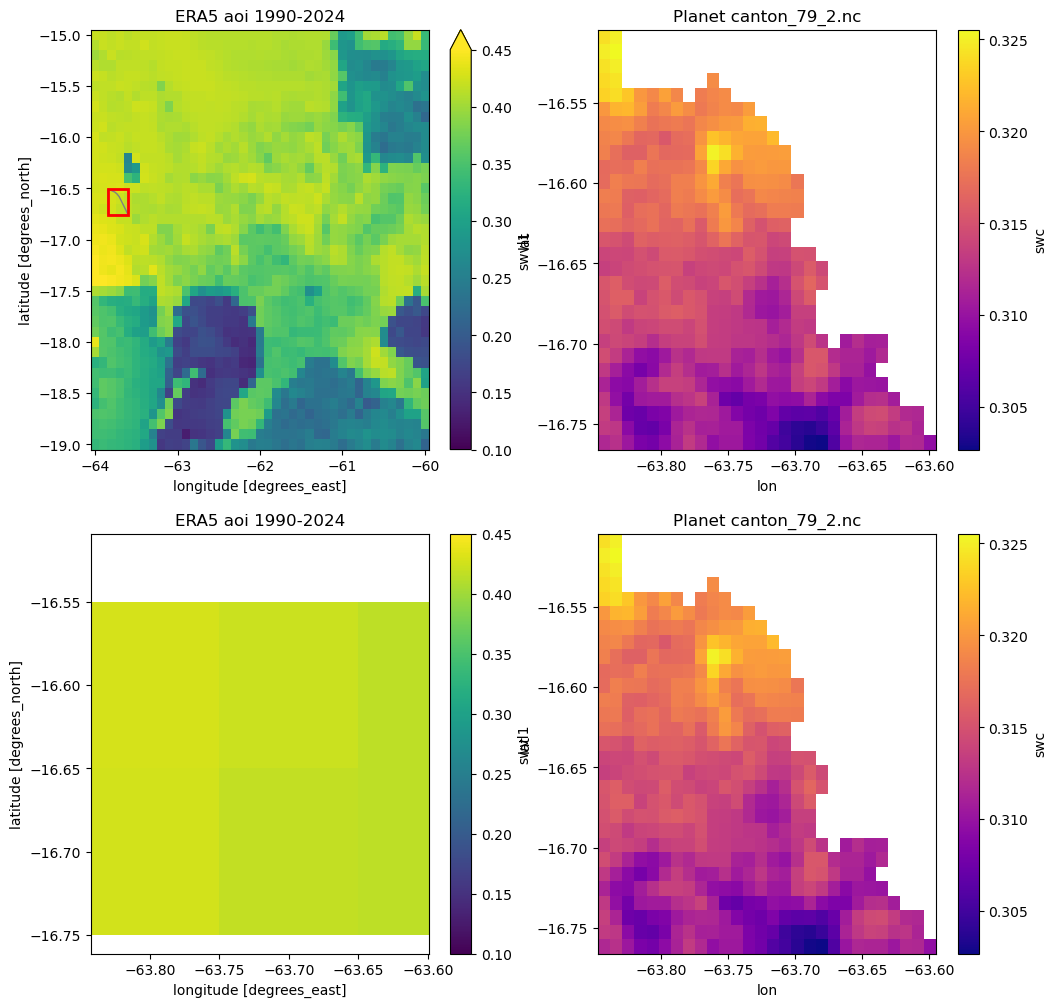

In [10]:
# compute and show mean variables to get the overview

var_era5 = ds_era5['swvl1']
swc_min_era5, swc_max_era5 = 0.1, 0.45

var_planet = ds_planet['swc']

lon_min, lon_max = ds_planet.lon.min().item(), ds_planet.lon.max().item()
lat_min, lat_max = ds_planet.lat.min().item(), ds_planet.lat.max().item()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

var_era5.mean(dim='time').plot(ax=axes[0,0], cmap='viridis', vmin=swc_min_era5, vmax=swc_max_era5)
axes[0,0].set_title("ERA5 aoi 1990-2024")

swc_mean = ds_planet['swc'].mean(dim='time')
        
# Find the coordinates of non-NaN values
non_nan_mask = ~np.isnan(swc_mean.values)
lon_coords, lat_coords = np.meshgrid(swc_mean.lon.values, swc_mean.lat.values)
non_nan_coords = np.column_stack([lon_coords[non_nan_mask], lat_coords[non_nan_mask]])
        
# Compute the convex hull around the non-NaN points
if non_nan_coords.size > 0:
    hull = ConvexHull(non_nan_coords)
    polygon_coords = non_nan_coords[hull.vertices]
else:
    polygon_coords = []
    
# Add the polygon if it exists
if polygon_coords.size > 0:
    poly_patch = Polygon(polygon_coords, closed=True, edgecolor='grey', facecolor='none', linewidth=1)
    axes[0,0].add_patch(poly_patch)

rect = Rectangle((lon_min, lat_min),  # esq inferior izquierda
                 lon_max - lon_min,  # width
                 lat_max - lat_min,  # height
                 linewidth=2, edgecolor='red', facecolor='none')
axes[0,0].add_patch(rect)

var_planet.mean(dim='time').plot(ax=axes[0,1], cmap='plasma')
axes[0,1].set_title("Planet " + inames_files )

var_era5_cropped = var_era5.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))

var_era5_cropped.mean(dim='time').plot(ax=axes[1,0], cmap='viridis', vmin=swc_min_era5, vmax=swc_max_era5)
axes[1,0].set_title("ERA5 aoi 1990-2024")
axes[1,0].set_xlim(lon_min, lon_max)
axes[1,0].set_ylim(lat_min, lat_max)

var_planet.mean(dim='time').plot(ax=axes[1,1], cmap='plasma')
axes[1,1].set_title("Planet " + inames_files)

fig.savefig('./figs/location_' + inames_files + '_with_ERA5.png', dpi=400)

### Comparison within all the cantones

In [9]:
# # Total path with all folders
# for ifolder in cantones_named_folders:
#     ipath_planet_cantones = path_planet_cantones + ifolder + '/'
#     print(f"Processing folder: {ifolder}")  # Print current folder
    
#     names_files = sorted(os.listdir(ipath_planet_cantones))
#     for inames_files in names_files:
#         try:
#             ds_planet = xr.open_dataset(ipath_planet_cantones + inames_files)
            
#             # Check for numeric data
#             if ds_planet['swc'].size == 0 or np.isnan(ds_planet['swc'].values).all():
#                 print(f"        Warning: No numeric data to plot in {inames_files}. Plotting NaNs.")
#                 # Generate an empty dataset for visualization
#                 ds_planet['swc'] = xr.full_like(ds_planet['swc'], np.nan)
#             plot_swc_mean(ds_era5, ds_planet, inames_files=inames_files)
#         except Exception as e:
#             print(f"        Error processing file {inames_files}: {e}")
#             continue  # Continue with the next file
# plt.close('all')

# print("All folders and files have been processed.")


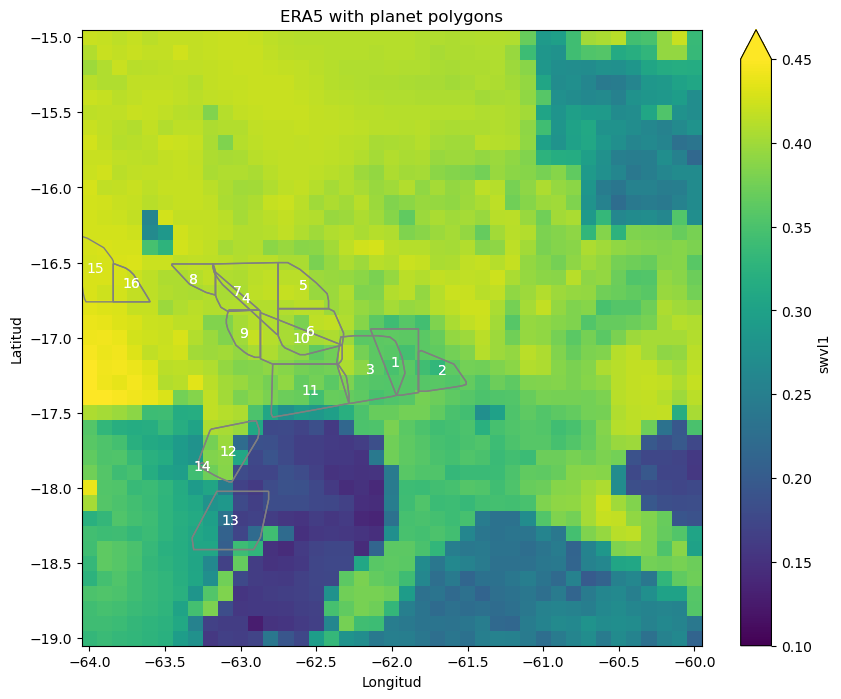

In [11]:
## all cantones

fig, ax = plt.subplots(figsize=(10, 8))
var_era5.mean(dim='time').plot(ax=ax, cmap='viridis', vmin=0.1, vmax=0.45)
ax.set_title("ERA5 with planet polygons")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

for idx, ifolder in enumerate(cantones_named_folders, start=1):
    ipath_planet_cantones = os.path.join(path_planet_cantones, ifolder)
    names_files = sorted(os.listdir(ipath_planet_cantones))
    for inames_files in names_files:
        ds_planet = xr.open_dataset(os.path.join(ipath_planet_cantones, inames_files))
        lon_min, lon_max = ds_planet.lon.min().item(), ds_planet.lon.max().item()
        lat_min, lat_max = ds_planet.lat.min().item(), ds_planet.lat.max().item()
    
            # Compute the mean along the time dimension
        swc_mean = ds_planet['swc'].mean(dim='time')
        
        # Find the coordinates of non-NaN values
        non_nan_mask = ~np.isnan(swc_mean.values)
        lon_coords, lat_coords = np.meshgrid(swc_mean.lon.values, swc_mean.lat.values)
        non_nan_coords = np.column_stack([lon_coords[non_nan_mask], lat_coords[non_nan_mask]])
        
        # Compute the convex hull around the non-NaN points
        if non_nan_coords.size > 0:
            hull = ConvexHull(non_nan_coords)
            polygon_coords = non_nan_coords[hull.vertices]
        else:
            polygon_coords = []
    
        # Add the polygon if it exists
        if polygon_coords.size > 0:
            poly_patch = Polygon(polygon_coords, closed=True, edgecolor='grey', facecolor='none', linewidth=1)
            ax.add_patch(poly_patch)
        
        ax.text(lon_min + (lon_max - lon_min) / 2, lat_min + (lat_max - lat_min) / 2,
                str(idx), color="white", fontsize=10, ha="center", va="center")

plt.savefig('./figs/era5_with_planet_polygons.png', dpi=300, bbox_inches='tight')
plt.show()


### explore the data within one canton

In [26]:
icanton_file = '../suyana/drought/capacity_example/raw/canton_79/canton_79_2.nc'
ds_planet = xr.open_dataset(icanton_file)

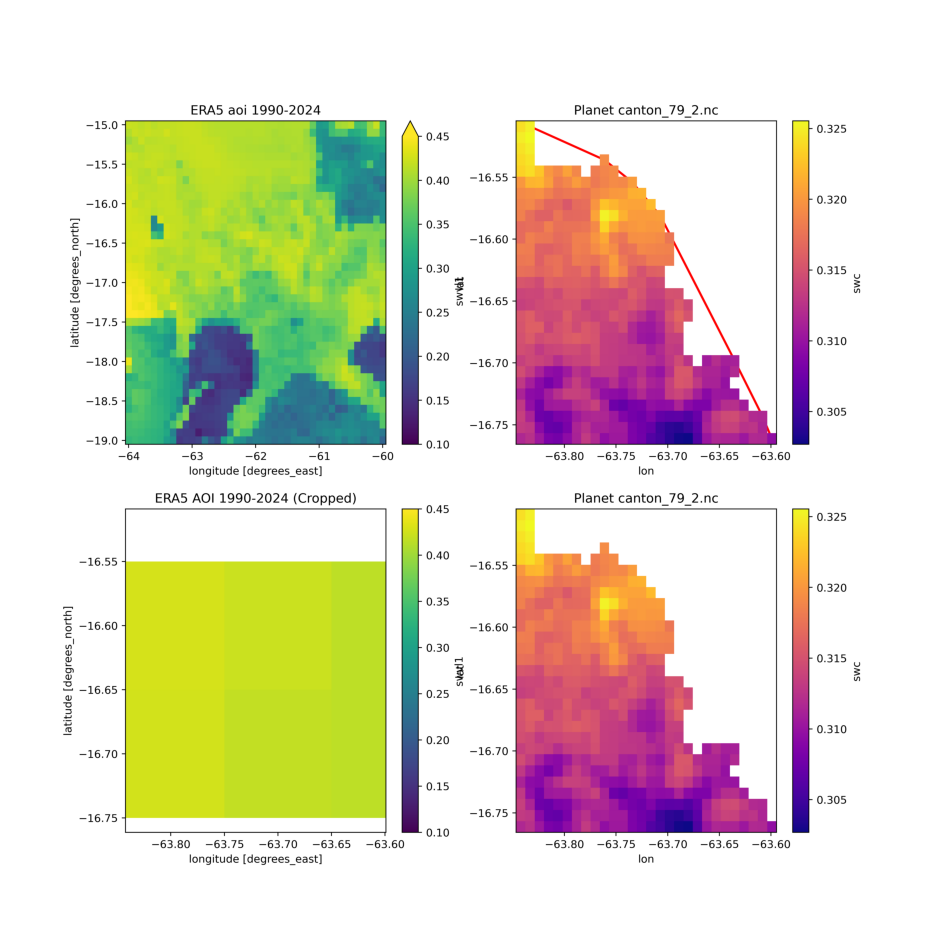

In [28]:
plot_swc_mean(ds_era5, ds_planet, inames_files='canton_79_2.nc')

# load and display the image
plt.figure(figsize=(12, 12))  
img = mpimg.imread('./figs/location_canton_79_2.nc_with_ERA5.png')
plt.imshow(img)
plt.axis('off') 
plt.show()


## clustering

                         SWC
Mean                0.314336
Median              0.315000
Standard Deviation  0.066141
Minimum             0.048000
Maximum             0.600000


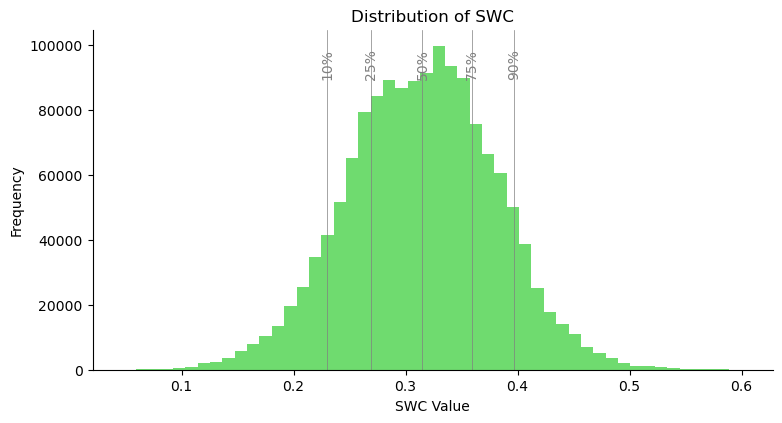

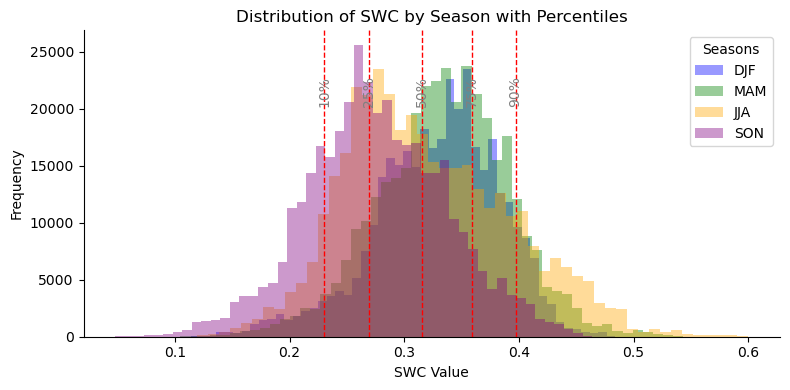

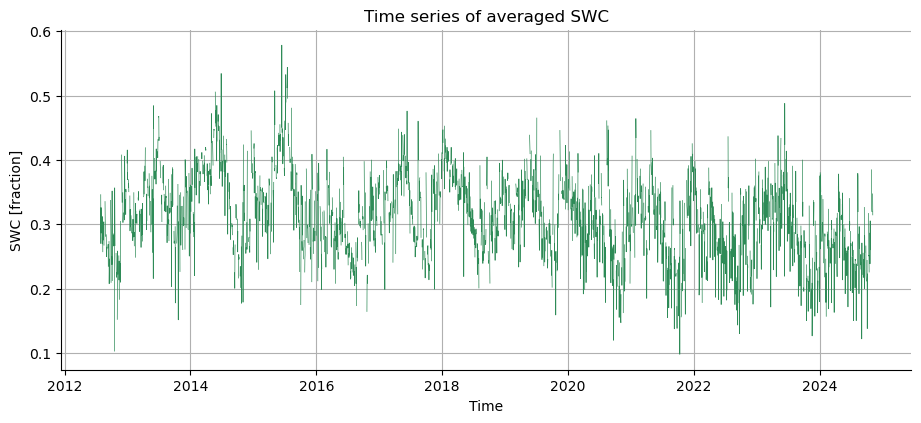

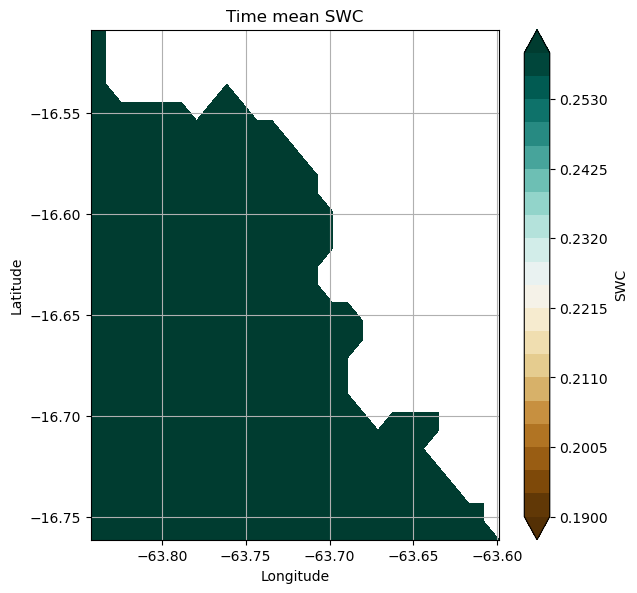

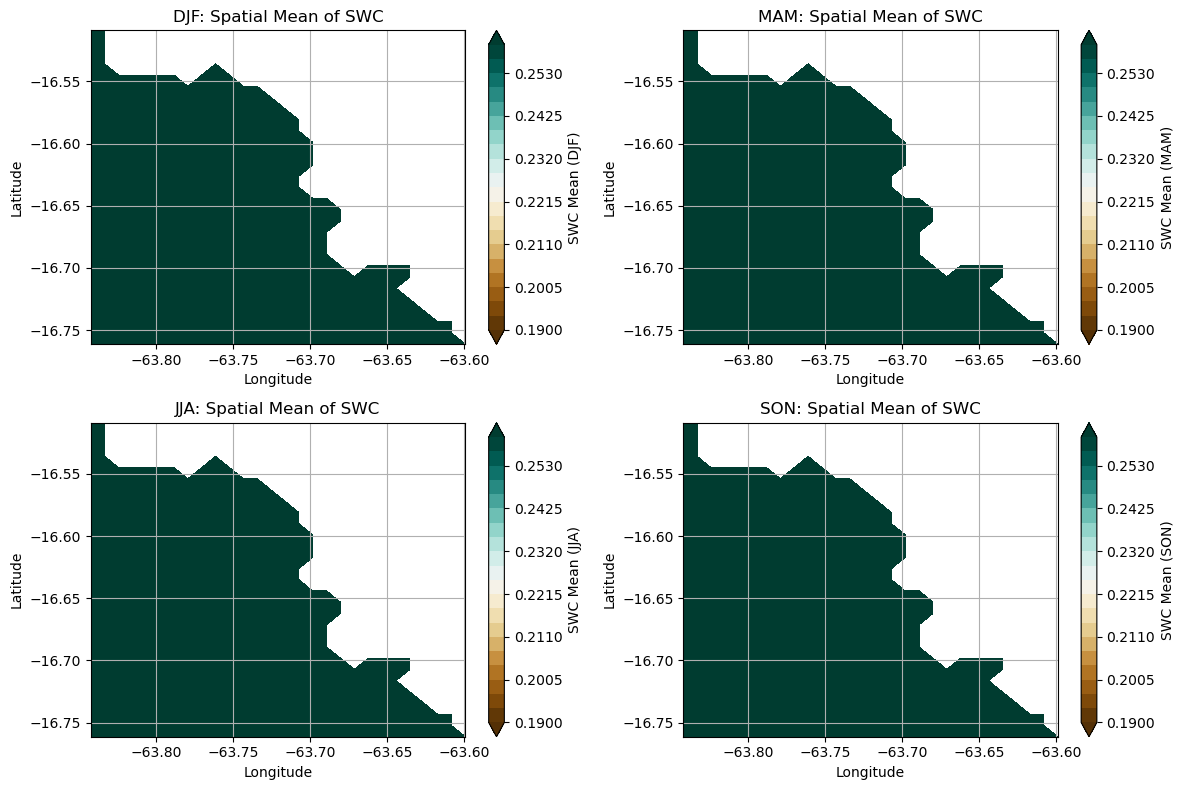

In [29]:
desc_stats = descriptive_statistics(ds_planet)
print(desc_stats)

plot_histogram(ds_planet)  # Plot histogram of SWC values
plot_histogram_by_season(ds_planet)
plot_time_series(ds_planet)  # Plot time series of average SWC
plot_spatial_mean(ds_planet)  # Plot spatial mean of SWC over time
plot_seasonal_spatial_means(ds_planet)


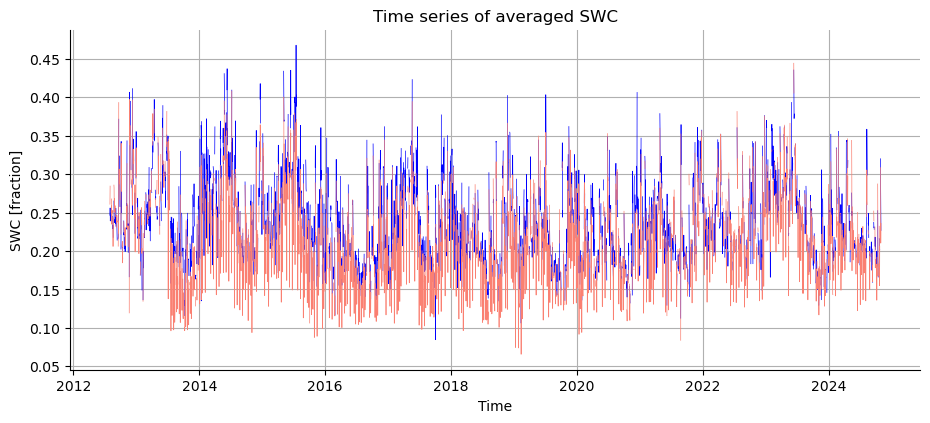

<Figure size 640x480 with 0 Axes>

In [25]:

data1 = ds_planet.sel(lat=slice(-17.18, -17.3), lon=slice(-62.8, -62.3))
data2 = ds_planet.sel(lat=slice(-17.48, -17.53), lon=slice(-62.8, -62.3))


plot_time_series_two(data1, data2)

plt.savefig('./figs/dataseries.png', dpi=400)


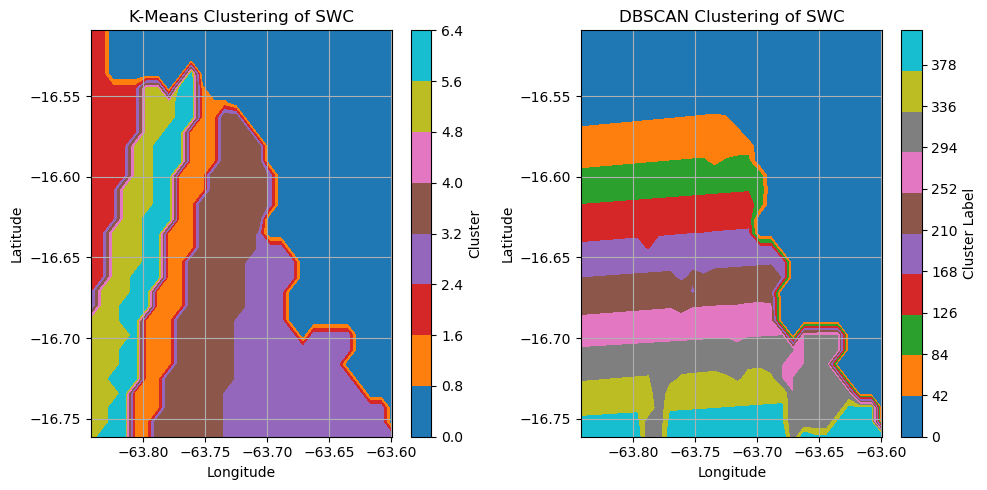

In [30]:
cluster_map_kmeans = perform_kmeans(ds_planet, n_clusters=7)
cluster_map_dbscan = perform_dbscan(ds_planet, eps=1, min_samples=1)
plot_clustering_results(ds_planet, cluster_map_kmeans, cluster_map_dbscan, n_clusters=7)


In [1]:
# Separate K-Means clusters
kmeans_clusters = separate_clusters(ds_planet, cluster_map_kmeans, n_clusters=7)

# Separate DBSCAN clusters
n_dbscan_clusters = len(np.unique(cluster_map_dbscan)) - (1 if -1 in cluster_map_dbscan else 0)
dbscan_clusters = separate_clusters(ds_planet, cluster_map_dbscan, n_clusters=n_dbscan_clusters)

# Access data for a specific cluster (e.g., cluster 0 from K-Means)
cluster_0_data = kmeans_clusters[0]


NameError: name 'separate_clusters' is not defined

In [ ]:
solver, anomalies = calculate_eofs(ds_planet, variable='swc', n_eofs=3)
plot_eofs_and_variance(ds_planet, solver, n_eofs=3)
